## Load libraries and helper functions

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline
prefix='./events/'

In [2]:
def fileconverter(filename,prefix):
    """
    function to convert txt file into json file
    """
    with open(prefix+filename+".txt","r") as f, open(prefix+filename+".json","w") as g:
        g.write('[\n')
        for i, line in enumerate(f,0):
            if i > 0 and line.strip() == '{':
                g.write(',\n{')
            else:
                g.write(line)
        g.write(']\n')
        
        
def from_sql_to_ts(query,db):
    """
    function to get timeseries data from database connection db 
    
    query: sql to query the database
    db connectuin to db
    
    This function does not open and close database connection!
    """    
    data = pd.read_sql(query, db)
    time_index = pd.DatetimeIndex(data['time'])
    data = data.set_index(time_index)
    data = data['duration'].groupby([pd.Grouper(freq='Min')]).sum()
    return data

        

## Data cleaning and database creation
the cell below should be run only once


In [3]:
# write related data into sql database, 

# create json files
"""
filelist = ['apache','applications','wes']
for file in filelist:
    fileconverter(file,prefix)

#create database    


db=sqlite3.connect('mydb.db')

fields = ['tkNameIdProvider','eventTime','durationMs', 'correlationId','callId']
data = pd.read_json(prefix+'applications.json')[fields]
data.to_sql(name = 'applications', con = db)


fields = ['dTB','dTF','corrID','logTime']
data = pd.read_json(prefix+'wes.json')[fields]
data.to_sql(name = 'wes', con = db)

fields=['time','corrID','logTime']
data=pd.read_json(prefix+'apache.json')[fields]
data.to_sql(name = 'apache', con = db)

db.close()
"""

"\nfilelist = ['apache','applications','wes']\nfor file in filelist:\n    fileconverter(file,prefix)\n\n#create database    \n\n\ndb=sqlite3.connect('mydb.db')\n\nfields = ['tkNameIdProvider','eventTime','durationMs', 'correlationId','callId']\ndata = pd.read_json(prefix+'applications.json')[fields]\ndata.to_sql(name = 'applications', con = db)\n\n\nfields = ['dTB','dTF','corrID','logTime']\ndata = pd.read_json(prefix+'wes.json')[fields]\ndata.to_sql(name = 'wes', con = db)\n\nfields=['time','corrID','logTime']\ndata=pd.read_json(prefix+'apache.json')[fields]\ndata.to_sql(name = 'apache', con = db)\n\ndb.close()\n"

## First task 

In [4]:
db=sqlite3.connect('mydb.db')

#get timeseries from different tables

query_application = ("SELECT tkNameIdProvider, eventTime, durationMs,callId "
                     "FROM applications")


d_application = pd.read_sql(query_application, db)

# set timeindex
d_application['eventTime'] = pd.to_datetime(d_application['eventTime'])
time_index = pd.DatetimeIndex(d_application['eventTime'])
d_application = d_application.set_index(time_index)

db.close()

# generate data for throughput
# According to the data dictionary, each call id identifies a single call

aggregated_data_applications_throughput = d_application[['tkNameIdProvider','callId']].groupby(
    [pd.Grouper(freq = 'Min'),'tkNameIdProvider']
).callId.nunique()

aggregated_data_applications_throughput = pd.DataFrame.unstack(aggregated_data_applications_throughput)


# generate data for worktime
aggregated_data_applications_worktime = d_application[['durationMs','tkNameIdProvider']].groupby(
    [pd.Grouper(freq = 'Min'),'tkNameIdProvider']
).sum()

aggregated_data_applications_worktime = pd.DataFrame.unstack(aggregated_data_applications_worktime)
aggregated_data_applications_worktime.columns = aggregated_data_applications_worktime.columns.droplevel()


# generate data for response time

# one approach is to query and aggregate data, the other is to simply divide worktime by throughput, 
# here we use the second approach to shorten the code

#aggregated_data_applications_responsetime = d_application[['durationMs','tkNameIdProvider']].groupby(
#    [pd.Grouper(freq = 'Min'),'tkNameIdProvider']
#).mean()

#aggregated_data_applications_responsetime = pd.DataFrame.unstack(aggregated_data_applications_responsetime)
#aggregated_data_applications_responsetime.columns = aggregated_data_applications_responsetime.columns.droplevel()

aggregated_data_applications_responsetime=aggregated_data_applications_worktime/aggregated_data_applications_throughput




/home/yzhang/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


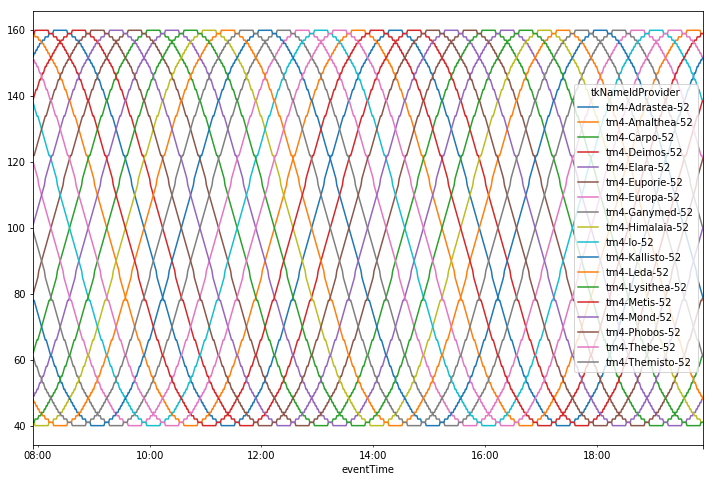

In [5]:
aggregated_data_applications_throughput.plot(figsize=(12,8))

/home/yzhang/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


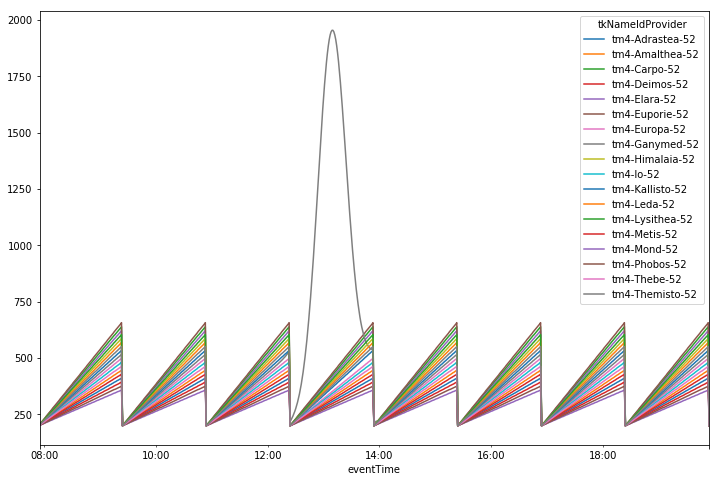

In [6]:
aggregated_data_applications_responsetime.plot(figsize = (12,8))

/home/yzhang/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


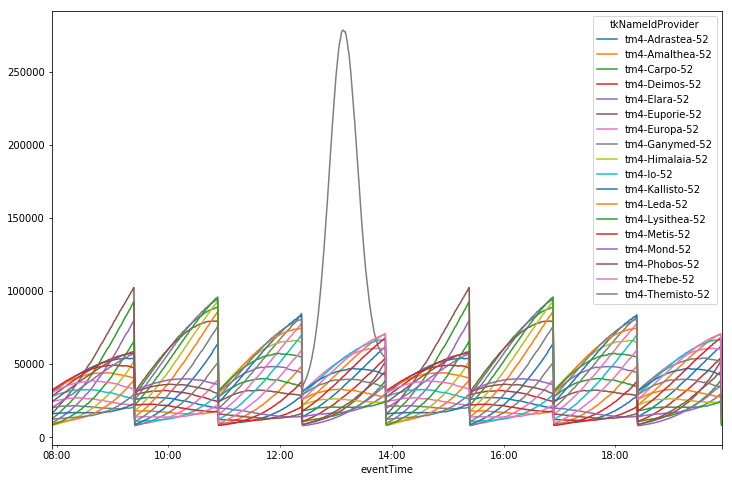

In [7]:
aggregated_data_applications_worktime.plot(figsize = (12,8))

## Second task

In [8]:
# the name of the component that we would like to explore
component_name = "'tm4-Ganymed-52'"

db=sqlite3.connect('mydb.db')

#get timeseries from different tables

query_application = ("SELECT eventTime AS time, durationMs AS duration "
                    "FROM applications "
                    "WHERE tkNameIdProvider = {}").format(component_name)

d_application = from_sql_to_ts(query_application,db)


#the definition of Worktime is somehow ambiguous in this dataset
# it could be the combination of dTB or dTF, or one of them.
#here I present both, which will help to understand the problem.
query_wes = ("SELECT wes.logTime AS time, wes.dTB+wes.dTF AS duration "
            "FROM wes "
            "WHERE wes.corrID "
            "IN ("
            "SELECT applications.correlationId FROM applications "
            "WHERE applications.tkNameIdProvider = {})").format(component_name)

d_wes = from_sql_to_ts(query_wes,db)


query_wes2 = ("SELECT wes.logTime AS time, wes.dTB AS duration "
            "FROM wes "
            "WHERE wes.corrID "
            "IN ("
            "SELECT applications.correlationId FROM applications "
            "WHERE applications.tkNameIdProvider = {})").format(component_name)

d_wes2 = from_sql_to_ts(query_wes2,db)





query_apache = ("SELECT apache.logTime AS time, apache.time AS duration "
            "FROM apache "
            "WHERE apache.corrID "
            "IN ("
            "SELECT applications.correlationId FROM applications "
            "WHERE applications.tkNameIdProvider = {})").format(component_name)

d_apache = from_sql_to_ts(query_apache,db)
db.close()



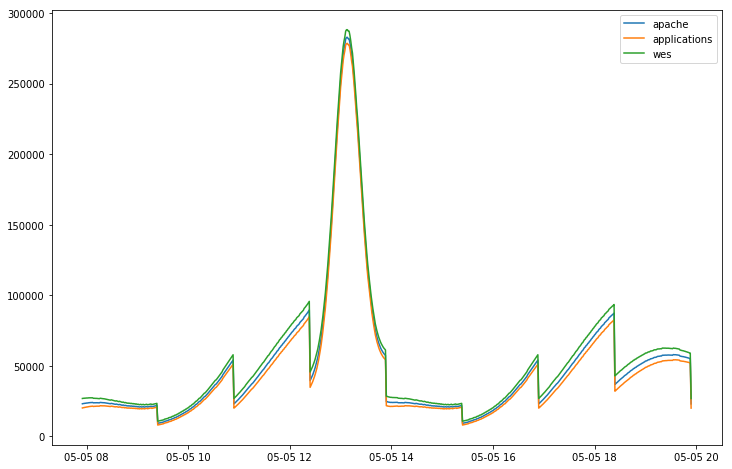

In [9]:
# plot all three figures in one plot
plt.figure(figsize = (12,8))
ax = plt.subplot()

# the unit is different for apache data
ax.plot(d_apache.index, d_apache/1000)
ax.plot(d_application.index, d_application)
ax.plot(d_wes.index, d_wes)

ax.legend(['apache','applications','wes'])

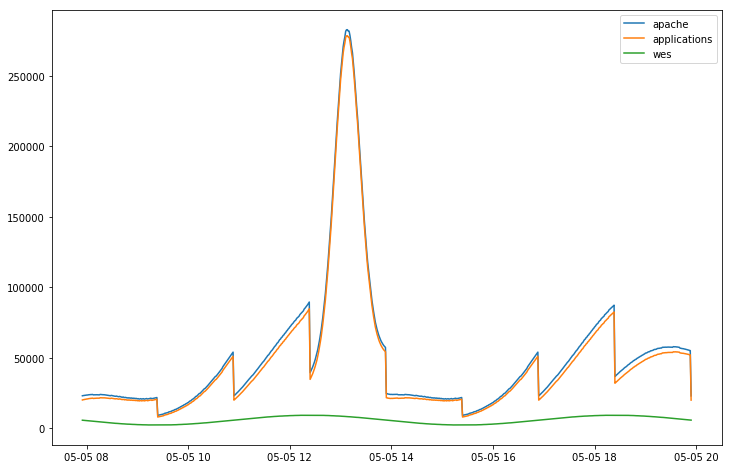

In [10]:
# plot all three figures in one plot
plt.figure(figsize = (12,8))
ax = plt.subplot()

# the unit is different for apache data
ax.plot(d_apache.index, d_apache/1000)
ax.plot(d_application.index, d_application)
ax.plot(d_wes2.index, d_wes2)

ax.legend(['apache','applications','wes'])